# Import

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import requests
import json
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import from_numpy,cat,softmax,squeeze,mean
import torch.nn.init as init
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import geom
from scipy.optimize import minimize

In [2]:
ONE_BPS = 0.0001

# Getting the data

## Schema to understand the formatting

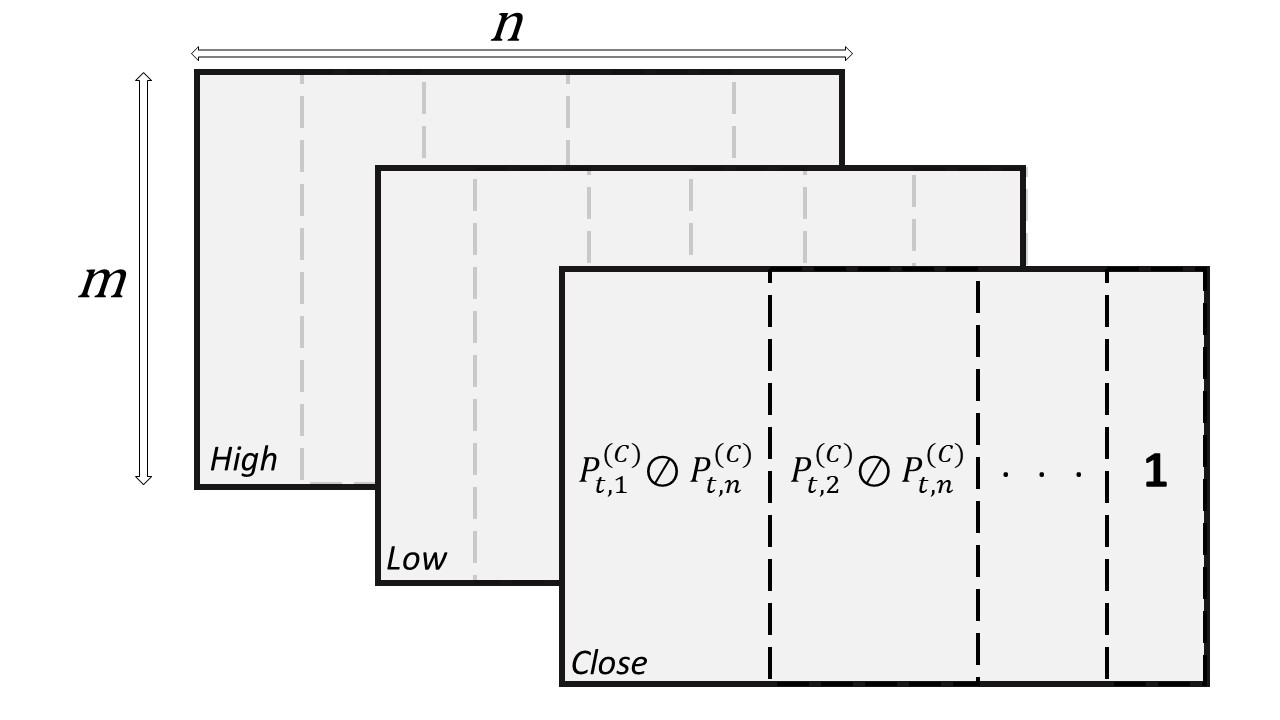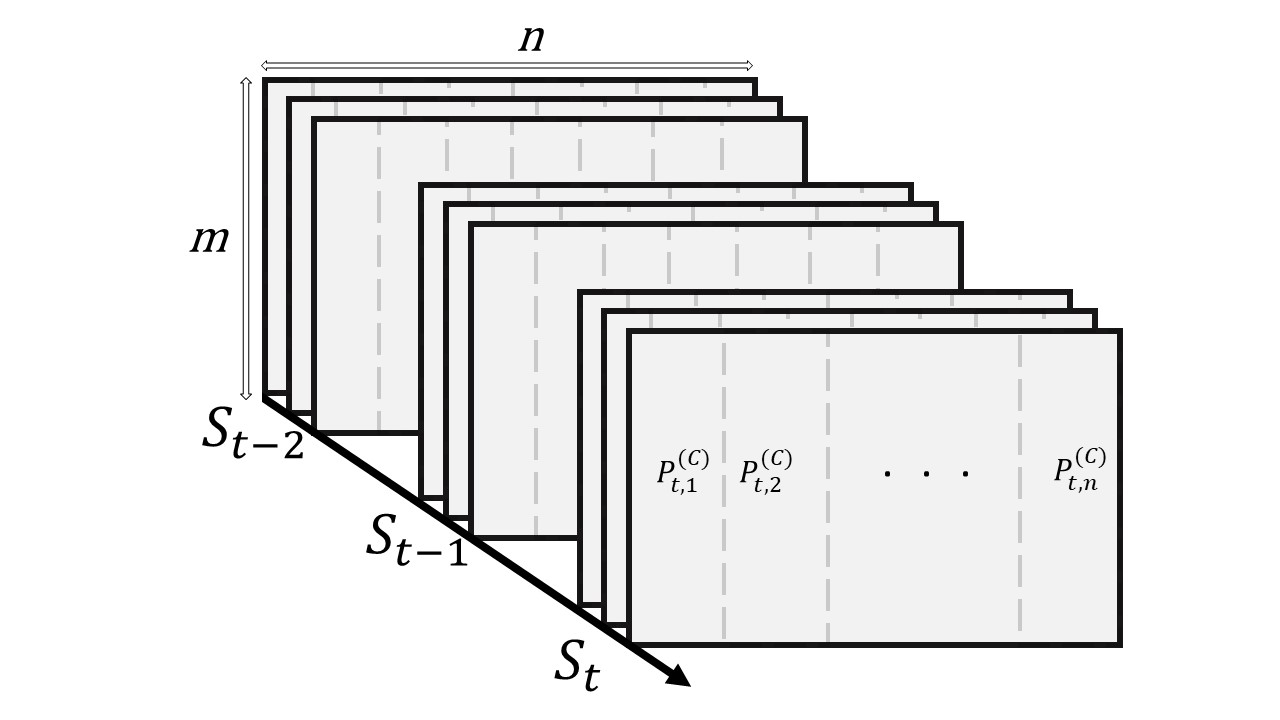

## Code

In [3]:
def check_product_exist(asset):
  """
  Check the list of products of Coinbase
    return False in 'asset' not in the list
  """
  url = 'https://api.pro.coinbase.com/products/'
  response = requests.get(url)
  data = []
  if response.status_code == 200:
    data = pd.DataFrame(json.loads(response.text))["id"].values
  return asset in data

In [4]:
sanitize_product = lambda l : [x for x in l if check_product_exist(x)] # Returns the list of product that **really** exist on the binance api when given a list of products

In [5]:
def fetch_data_one_asset(asset:str,start:datetime.datetime,end:datetime.datetime, granularity : int = 900) -> pd.DataFrame:
    """
    Get the 15min interval data for an asset between two dates : start & end
    -> Check the product exists before making the calls
    -> Splits the time-interval between start and end in slots since coinbase doesn't allow more than 300 datapoints per API call

    Returns : DataFrame : index = date | columns OHLCV 
    """
    if not check_product_exist(asset):
      print(f"\nTicker unavailable : {asset}")
      return pd.DataFrame()
    print(f"Fetching data for : {asset}")
    start_ts = int(start.timestamp())
    end_ts = int(end.timestamp())

    limit_data_point = 300
    time_interval_sec = 15

    time_interval_per_df = limit_data_point * time_interval_sec

    count_df = (end_ts-start_ts) // time_interval_per_df +1 
    all_data = []

    start_temp = start_ts
    end_temp= start_ts + time_interval_per_df
    end_temp = end_temp if end_temp<end_ts else end_ts

    for count_req in tqdm(range(count_df)):
      data = pd.DataFrame()
      url = f'https://api.pro.coinbase.com/products/{asset}/candles?granularity={granularity}&start={start_temp}&end={end_temp}'
      response = requests.get(url)
      if response.status_code == 200:  # check to make sure the response from server is good
          data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
      all_data.append(data)

      start_temp = end_temp
      end_temp = end_temp + time_interval_per_df
      end_temp = end_temp if end_temp<end_ts else end_ts 

      if (count_req+11)%10==0: # 10 request per 1 seconds
        time.sleep(1)

    res = pd.concat(all_data)
    if "unix" in res.columns:
      res['date'] = pd.to_datetime(res['unix'], unit='s')
      res = res.drop("unix",axis=1)
      res = res.set_index("date")
    return res   

In [6]:
def fetch_data_all_assets(assets : list,start :datetime.datetime,end :datetime.datetime,granularity : int = 900) -> pd.DataFrame:
    """
    Get the 15min interval data for a list of assets between two dates : start & end
    Returns : DataFrame : index = date | columns product -> OHLCV  (=5 * n_assets columns)
    """
    all_data = []
    for asset in assets:
        data = fetch_data_one_asset(asset,start,end,granularity = granularity)
        all_data.append(data)
        time.sleep(2)
    res = pd.concat(all_data,keys=assets,axis=1).swaplevel(0,1,axis=1).sort_index(axis=1)
    res.index = pd.to_datetime(res.index)
    res = res.sort_index(ascending=False)
    res = res.drop(["volume","open"],axis=1)
    res = res.fillna(method="ffill",axis=0).dropna()
    return res

In [7]:
def data_process(data:pd.DataFrame,assets:list,n : int) -> np.ndarray:
    """
    data : data multilevel close high low => m assets
    assets : list of string assets : columns of second level of data
    n : time interval in one period (mutlitple of 4 better (4*15=60 =>even hours))

    returns : 

        Tensor of size :
            T = nnumber of data points in "data" //number of time interval per block => number of time interval
            3 = Close,High,Low
            n = number of datapoint per "block"
            m = number of assets
    """
    df = data.copy().fillna(method="ffill").fillna(method="bfill").dropna()
    df = df.iloc[:data.shape[0]//n * n,:] # make sure we have correct size to split in batch of n-period per 

    m = len(assets)

    close_end_period = np.repeat(df["close"].values[::n],n,axis=0)
    df["close"] = df["close"] / close_end_period
    df["high"] = df["high"] / close_end_period
    df["low"] = df["low"] / close_end_period
    
    df = df.sort_index(ascending=True) # put the time back in place (from oldest to most recent)

    close_tensor = df["close"].values.reshape(df["close"].shape[0]//n,n,m)
    high_tensor = df["high"].values.reshape(df["high"].shape[0]//n,n,m)
    low_tensor = df["low"].values.reshape(df["low"].shape[0]//n,n,m)

    res = np.array([close_tensor,high_tensor,low_tensor])
    res = res.transpose((1, 0, 3, 2))
    corresponding_index = df.index[::n].values
        
    return df,corresponding_index,res

In [8]:
start_date=datetime.datetime.today() - datetime.timedelta(days=2)
end_date=datetime.datetime.today() - datetime.timedelta(days=1)
cryptos_sample = sanitize_product(["BTC-USDT","ETH-USDT","DOGE-USDT"])
data = fetch_data_all_assets(cryptos_sample, start=start_date, end=end_date)
def test_data_process(data):
  n = 24
  m = 4
  df_raw,index,all_batches = data_process(data,cryptos_sample,n=n)
  print(all_batches.shape)
test_data_process(data)

Fetching data for : BTC-USDT


100%|██████████| 20/20 [00:03<00:00,  6.24it/s]


Fetching data for : ETH-USDT


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Fetching data for : DOGE-USDT


100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


(4, 3, 3, 24)


## Util function

### Numpy -> Tensor

In [9]:
def numpy_to_torch(array:np.ndarray,new_shape : tuple = None):
  array_ = array if new_shape is None else np.reshape(array,new_shape)
  res_tensor = torch.from_numpy(array_).type(torch.float32)
  res_tensor.requires_grad = True
  return res_tensor

### Portfolio management theory

In [10]:
def performance_metric(portfolios: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the Sharpe ratio, percentage return, final price, and maximum drawdown
    of each portfolio in the input DataFrame.

    Args:
        portfolios (pd.DataFrame): A DataFrame of portfolio values over time, with
            one column for each portfolio.

    Returns:
        pd.DataFrame: A DataFrame with columns for each portfolio and rows for each metric.
            The metrics are Sharpe ratio, percentage return, final price, and maximum drawdown.
    """

    # Compute daily returns of the portfolios
    daily_returns = portfolios.pct_change().dropna()

    # Compute annualized expected return, volatility, and Sharpe ratio
    annual_return = daily_returns.mean() * 252
    annual_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility

    # Compute cumulative returns of the portfolios
    cumulative_returns = (1 + daily_returns).cumprod()

    # Compute final price and maximum drawdown of the portfolios
    final_price = portfolios.iloc[-1]
    peak = portfolios.cummax()
    drawdown = (portfolios - peak) / peak
    max_drawdown = drawdown.min()

    # Combine the metrics into a single DataFrame
    metrics = pd.DataFrame({
        'Sharpe ratio': sharpe_ratio,
        '% return': (final_price / portfolios.iloc[0] - 1) * 100,
        'Final price': final_price,
        'Max drawdown': max_drawdown
    })

    return metrics

In [11]:
def markowitz_weights(price: pd.DataFrame) -> np.array:
    """
    Calculates the Markowitz portfolio weights for the given price data.

    Args:
        price (pd.DataFrame): A datetime-indexed DataFrame of historical prices
            for a set of assets. Each column represents an asset.

    Returns:
        np.array: A numpy array of portfolio weights, where each weight
            corresponds to the respective asset column in the input DataFrame.
    """

    # Calculate the expected returns of the assets
    returns = price.mean()

    # Calculate the covariance matrix of the assets
    covariance_matrix = price.cov()

    # Define the risk tolerance of the investor (lambda)
    lambda_ = random.random()

    # Define the optimization objective function to minimize the negative portfolio return
    def objective(weights):
        portfolio_return = np.dot(weights, returns)
        portfolio_volatility = np.sqrt(np.dot(np.dot(weights, covariance_matrix), weights.T))
        return -1 * (portfolio_return - lambda_ * portfolio_volatility)

    # Define the optimization constraint that ensures weights are non-negative
    constraints = [{'type': 'ineq', 'fun': lambda x: x}]

    # Define the initial weights
    initial_weights = np.ones(len(returns)) / len(returns)

    # Perform the constrained optimization to find the optimal portfolio weights
    result = minimize(objective, initial_weights, constraints=constraints, method='SLSQP')
    weights = result.x / np.sum(result.x)

    return weights

sample = np.array([[100,10,50],[105,5,50],[110,10,51],[115,15,55]])
price_sample = pd.DataFrame(sample,columns = ["A","B","C"])
display(price_sample)
print(markowitz_weights(price_sample))

,A,B,C
0,100,10,50
1,105,5,50
2,110,10,51
3,115,15,55


[0.63758194 0.0554365  0.30698156]


In [12]:
def simulate_portfolio_wealth(prices: np.ndarray, weights: np.ndarray, C: float,fee_func : callable) -> np.ndarray:

    returns = np.diff(prices, axis=0) / prices[:-1]
    wealth = np.zeros(len(prices))
    wealth[0] = C
    for step in range(0,len(prices)-1):
        fee_penalty = (1-fee_func(weights[step],weights[step+1]))
        previous_wealth = wealth[step] 
        return_on_wealth = (1+returns[step]) @ weights[step]
        wealth[step+1] =  previous_wealth * return_on_wealth * fee_penalty
    return wealth

In [62]:
def test_simulate_pf_wealth():
  prices = data["close"].values
  weights_all = np.ones_like(prices) * 1/prices.shape[1]
  weights_one = weights_all.copy()
  ones = np.zeros((len(weights_one)-len(weights_one)//2,prices.shape[1]))
  ones[:,0] = 1.
  weights_one[len(weights_one)//2:] = ones
  wealth_all = simulate_portfolio_wealth(prices=prices,weights = weights_all , C = 100, fee_func = lambda x,y : 0.)
  wealth_one = simulate_portfolio_wealth(prices=prices,weights = weights_one , C = 100, fee_func = lambda x,y : 0.)
  prices = (prices - prices.min(axis=0)) / (prices.max(axis=0) - prices.min(axis=0))
  fig , axs = plt.subplots(1,2,figsize=(8,3))
  ax = axs[0]
  ax.plot(prices)
  ax = axs[1]
  ax.plot(wealth_all,linestyle="--",color ="red",label="all")
  ax.plot(wealth_one,linestyle="--",color ="red",label="one")
  ax.legend()

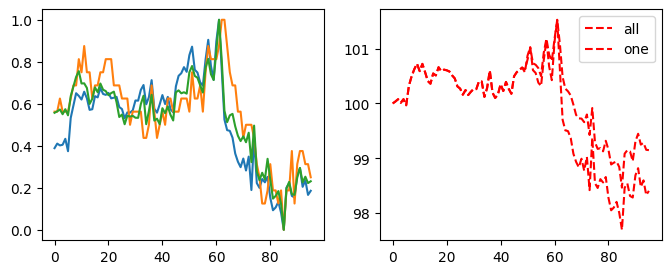

In [63]:
test_simulate_pf_wealth()

### Reinforcement Learning reward $r_t$ computation

In [15]:
def get_mu_t(wt_1:np.ndarray,wt:np.ndarray,fees = 0.015):
    """
    Compute the cum_fees to pass from wt_1 to wt weights with transactions costs "fees"
    fees : set to 100bps
    """
    cum_fees = np.abs((wt-wt_1)).sum() * fees
    return cum_fees/2.

In [16]:
def get_mu_t_torch(wt_1, wt, fees=0.015):
    """
    Compute the cum_fees to pass from wt_1 to wt weights with transactions costs "fees"
    fees : set to 100bps
    """
    cum_fees = torch.abs(wt - wt_1).sum(axis=1) * fees
    return cum_fees / 2.


def get_yt_torch(Xt):
    """
    return the price relative vector y_t of the t_th trading period
    """
    risky_assets_return = Xt[:,0,:, -2]
    batch_size = risky_assets_return.shape[0]
    added_risk_free_returns = torch.ones(batch_size,1)
    return torch.cat((risky_assets_return,added_risk_free_returns),dim=1)


def get_rt_torch(Xt, wt_2, wt_1,fees = 0.015):
    yt = get_yt_torch(Xt)  # "relative return" from period Xt
    mu_t = get_mu_t_torch(wt_2, wt_1,fees = fees)  # how much it costed to go from w(t-2) to w(t-1)
    log_rt = torch.log((1-mu_t)*torch.sum(yt * wt_1,dim = 1))
    normed_rt = torch.mean(log_rt)
    return normed_rt

wt_2 = numpy_to_torch(np.array([[1.,0.,0.,0.],[1.,0.,0.,0.],[1.,0.,0.,0.]]))
wt_1 = numpy_to_torch(np.array([[0.,0.,0.,1.],[0.,0.,0.,1.],[0.,0.,0.,1.]]))

_,_,ss = data_process(data,cryptos_sample,n=4)
xx = numpy_to_torch(ss)[:3]
get_rt_torch(xx,wt_1, wt_2)

tensor(-0.0159, grad_fn=<MeanBackward0>)

# Replay Buffer

In [17]:
class Env_PVM:

  def __init__(self,m : int , n : int,batch_size_N_b : int, mini_batch_lenght_n_b : int,training_data : np.ndarray,cryptos : list,beta : float = 0.35):

    self.m = m
    self.n = n 
    self.batch_size_N_b = batch_size_N_b
    self.mini_batch_lenght_n_b = mini_batch_lenght_n_b # rraw N_b mini_batch, each spaning across mini_batch_lenght (n_b) episodes  
    self.training_data = training_data
    self.drawing_distrib = geom(beta)

    self.portfolio_memory = np.zeros((len(training_data),m+1))
    self.portfolio_memory[:,-1]= 1.

    self.current_portfolio = np.zeros(m+1)
    self.current_portfolio[-1] = 1.

    self.cryptos = cryptos

    self.current_timestep = 0
    self.max_timestep = len(self.training_data) -1

  def get_current_portfolio(self):
      return self.current_portfolio

  def set_and_store_new_portfolio(self,timestep,portfolio):
    self.current_portfolio = portfolio
    self.portfolio_memory[timestep] = portfolio

  def normalize_weight(self,weight):
      return weight / weight.sum()

  def get_random_weight(self):
      return self.normalize_weight(np.random.random(self.m+1))

  def reset_portfolio_memory(self):
      self.portfolio_memory = np.ones((len(self.training_data),m)) * 1/m

  def get_max_timestep(self):
      return self.max_timestep

  def get_cryptos(self):
      return self.cryptos

  def get_state_at_timestep(self,timestep):
      return self.training_data[timestep]

  def draw_random_batch(self,t : float):
    """
    Draw N_b minibatches of each n_b episodes inside
    Compute the rewards for each N_b mini_batches and returns it
    """
    rewards = np.zeros((self.batch_size_N_b))

    batches_portfolio_weights = np.zeros((self.batch_size_N_b,self.mini_batch_lenght_n_b,self.m+1))
    batches_portfolio_weights[:,:,-1] = 1.

    states = np.zeros((self.batch_size_N_b,self.mini_batch_lenght_n_b,3,self.m,self.n))

    for mini_batch_index in range(self.batch_size_N_b):
      t_b = t - self.mini_batch_lenght_n_b - self.drawing_distrib.rvs() + 1
      t_b = max(t_b,0) # ensure t_b is not negative
      
      batches_portfolio_weights[mini_batch_index] =  self.portfolio_memory[t_b:t_b+self.mini_batch_lenght_n_b]
      states[mini_batch_index] = self.training_data[t_b:t_b+self.mini_batch_lenght_n_b]

    return batches_portfolio_weights,states

  def store_portfolio_weight(self,t:float,weight : np.ndarray):
      self.portfolio_memory[t] = weight

# Actor/Policy Network

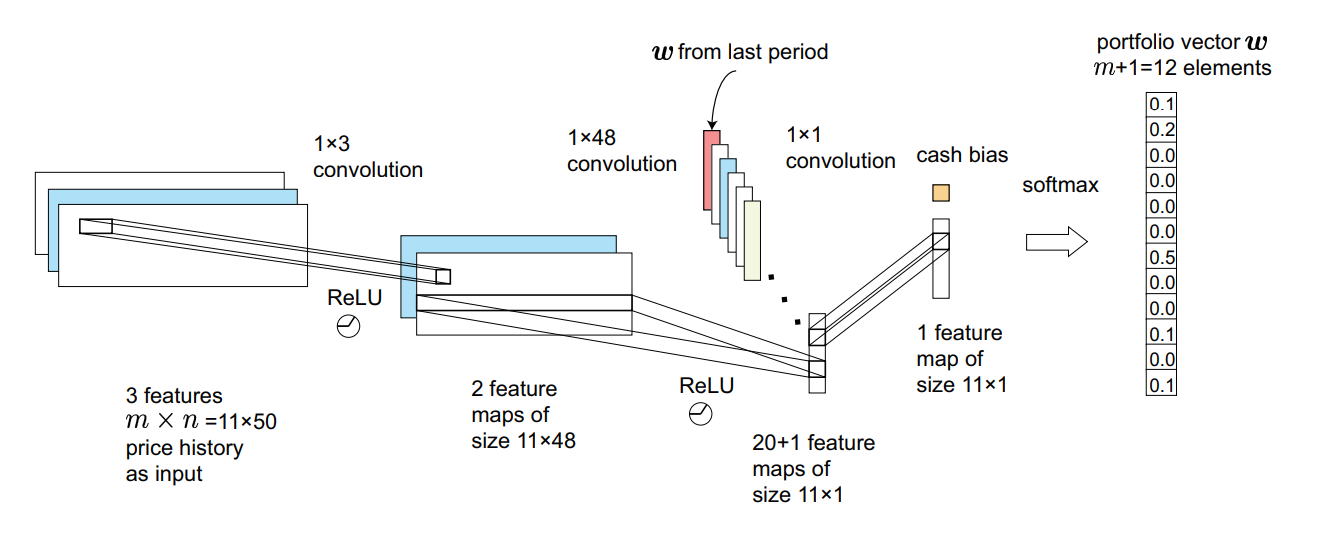

In [18]:
class ActorNetwork(nn.Module):
    def __init__(self, m=2,n=50,k = 20,cash_bias : float = 1.,cash_bias_update_rate : float = .5):
        super(ActorNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 2,kernel_size = (1,3))
        self.conv2 = nn.Conv2d(in_channels = 2,out_channels = k,kernel_size = (1,n-2))
        self.conv3 = nn.Conv1d(in_channels = k+1,out_channels =1,kernel_size = (1))

        self.cash_bias = cash_bias
        self.cash_bias_update_rate = cash_bias_update_rate
        self.n = n
        self.m = m
        self.init_weights()

    def init_weights(self):

        init.xavier_uniform_(self.conv1.weight.data)
        init.constant_(self.conv1.bias.data, .0)
        init.xavier_uniform_(self.conv2.weight.data)
        init.constant_(self.conv2.bias.data, .0)
        init.xavier_uniform_(self.conv3.weight.data)
        init.constant_(self.conv3.bias.data, .0)

    def forward(self, mainInput, weightInput):
        batch_size = mainInput.shape[0]
        x = F.relu(self.conv1(mainInput))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,start_dim = 2)
        x = torch.cat((x, weightInput), dim=1)
        x = self.conv3(x)
        x = torch.flatten(x,start_dim=1)
        biasInput = torch.ones(batch_size,1) * self.cash_bias
        x = torch.cat((x, biasInput),dim=1)
        mOut = F.softmax(x, dim=1)
        return mOut


    def set_cash_bias(self, mainInput,weightInput):
        batch_size = mainInput.shape[0]
        x = F.relu(self.conv1(mainInput))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,start_dim = 2)
        x = torch.cat((x, weightInput), dim=1)
        x = self.conv3(x)
        x = torch.flatten(x,start_dim=1)
        res = torch.mean(x).detach().numpy()
        self.cash_bias = self.cash_bias * (1-self.cash_bias_update_rate) + self.cash_bias_update_rate * res

In [19]:
N_in = 1
n_in = 50
m_in = 4

network_example = ActorNetwork(m=m_in,n=n_in)
states_example = torch.randn(N_in, 3, m_in, n_in)
weigth_example = torch.randn(N_in,1,m_in)
mOut = network_example(states_example, weigth_example)
print(mOut)

tensor([[0.1866, 0.1365, 0.1143, 0.2114, 0.3512]], grad_fn=<SoftmaxBackward0>)


# Agent

In [20]:
class Agent:

  def __init__(self,pvm : Env_PVM,lr_policy=0.1,n=8,m=4,tau = 0.5,fees = 0.025,l2_weight_decay = 1e-8,network_class= ActorNetwork,network_k :int = 20,cash_bias :float = 1.,cash_bias_update_rate : float = .5):
      self.n = n
      self.m = m
      self.memory = pvm

      self.fees = fees

      self.tau = tau
      self.noise = 0.01

      self.lr_policy = lr_policy

      self.mini_batch_lenght_n_b = pvm.mini_batch_lenght_n_b

      self.actor = network_class(n=n,m=m, k =network_k,cash_bias = cash_bias)
      self.target_actor = network_class(n=n,m=m, k =network_k, cash_bias = cash_bias,cash_bias_update_rate=cash_bias_update_rate)

      self.loss = nn.MSELoss()

      self.actor_optimizer = optim.Adam(params=self.actor.parameters(), lr=lr_policy)

      self.update_network_parameters(0.)

  def update_network_parameters(self,tau = None):
      """
      Update weights from field to target network with a softparam tau (in ]0,1[)
      tau == 1 => network doesn't move
      tau == 0 => direct copy
      """
      if tau is None:
          tau = self.tau

      new_weights = dict()
      target_weight= self.actor.state_dict()

      for param_set,param_val in self.target_actor.state_dict().items():
          new_weights[param_set] = param_val * tau   + (1-tau) * target_weight[param_set]
      self.target_actor.load_state_dict(new_weights)

  def choose_action(self,state,previous_portfolio,evaluate = False):
      """
      From a state (np.array) and the previous portfolio (shape (m+1)) returns the prediction of the best portfolio for next step
      """
      previous_portfolio_risky = previous_portfolio[:-1]
      previous_portfolio_input = numpy_to_torch(previous_portfolio_risky,new_shape = (1,1,self.m))
      state_input = numpy_to_torch(state,new_shape = (1,3,self.m,self.n))
      weight_output = self.actor(state_input,previous_portfolio_input)[0]
      if not evaluate:
        weight_output += torch.normal(mean=0., std=torch.full((self.m+1,),self.noise)) # add noise
      weight_output = weight_output.detach().numpy()
      weight_output = np.abs(weight_output) / np.abs(weight_output).sum()
      return weight_output

  def learn(self,t : int):
      """
      Draws random batch (geometric distribution) => compute the loss(=-reward) for each batch => perform gradient ascent/descent on the reward/loss
      """
      self.actor.train()
      portfolio_weights,states = self.memory.draw_random_batch(t =t)
      average_loss = []
      for state,portfolio_weight in zip(states,portfolio_weights):
        portfolio_weight_risky_asset = portfolio_weight[:,:-1]
        self.actor_optimizer.zero_grad()

        state_input = numpy_to_torch(state)
        portfolio_weight_input = numpy_to_torch(portfolio_weight_risky_asset,new_shape = (self.mini_batch_lenght_n_b,1,self.m))
        portfolio_weight_output = self.actor(state_input,portfolio_weight_input) 

        loss = -get_rt_torch(state_input,numpy_to_torch(portfolio_weight),portfolio_weight_output,fees = self.fees)
        loss.backward()

        self.actor_optimizer.step()
        self.actor.set_cash_bias(state_input,portfolio_weight_input)

        detached_loss = loss.detach().numpy()
        average_loss.append(detached_loss)
      self.update_network_parameters()
      return sum(average_loss) / len(average_loss)

  def backtest(self,raw_data_test,data_test,index_data_test,fees_override : float = None):
    """
    Using rax data (for price) and formatted data (for CNN inputs) and a fees parameter (nullable) => returns the dataframe of prices of dummy portfolios :
        The value portfolio : Choose the best performing stock for the first half of the test period (some look-ahead bias) and assign all our wealth in this stock
        The 1/N portfolio : Assign a wealth of 1/mto each asset in our environment, no assessment of correlation of risk
        The Markowitz portfolio : Using portfolio theory, construct the Markowitz portfolio without re-balancing during the test period. We use a random risk-aversion parameter lambda for the optimisation. 
    """
    df = raw_data_test.close.copy()
    df = df.loc[index_data_test]
    df["USDT-USDT"] = 1. #fill risk_free asset

    cryptos = self.memory.get_cryptos() + ["USDT-USDT"]

    n_steps = len(data_test)

    portfolio_hist = np.zeros((n_steps,self.m+1))

    tot_reward = 0
    portfolio = np.zeros((self.m+1))
    portfolio[-1] = 1

    capital = 1000.

    for step in range(n_steps):
      state = data_test[step]
      new_portfolio = self.choose_action(state=state,previous_portfolio = portfolio,evaluate = True)
      portfolio = new_portfolio
      portfolio_hist[step] = portfolio

    new_scalar_dict_weight = {f"{cpto}_weight" : portfolio_hist[:,i] for i,cpto in enumerate(cryptos)}

    df = df.assign(**new_scalar_dict_weight)

    prices = df[cryptos].to_numpy()

    one_over_n_weights = np.ones((n_steps,m+1)) * 1/(m+1)
    mar_weights_one_row = markowitz_weights(price = df[cryptos].drop("USDT-USDT",axis=1))
    mar_weights = np.tile(np.concatenate((mar_weights_one_row,np.zeros(1))), (n_steps, 1))

    sample_price_for_value_pf = prices[:len(prices)//2,:-1]
    best_asset_half_period = (sample_price_for_value_pf[-1] / sample_price_for_value_pf[0]).argmax()
    print("\nValue stock is ",cryptos[best_asset_half_period])
    print(f"Markowitz weights : {' | '.join([f'{c}: {w:.2f}' for c,w in zip(cryptos,mar_weights_one_row)])}")
    value_weight = np.zeros((n_steps,m+1))
    value_weight[:,best_asset_half_period] = 1.

    fee_backtest = fees_override if fees_override is not None else self.fees
    fee_func = lambda wt,wt_1 : get_mu_t(wt=wt,wt_1 = wt_1, fees=fee_backtest)
    print(f"Fees backtest : {fee_backtest/ONE_BPS} BPS")

    actor_portfolio_wealth = simulate_portfolio_wealth(prices = prices,weights = portfolio_hist,C = capital,fee_func = fee_func)
    one_over_n_portfolio_wealth = simulate_portfolio_wealth(prices = prices,weights = one_over_n_weights,C = capital,fee_func = fee_func)
    markowitz_wealth = simulate_portfolio_wealth(prices = prices,weights = mar_weights,C = capital,fee_func = fee_func)
    value_stock_wealth = simulate_portfolio_wealth(prices = prices,weights = value_weight,C = capital,fee_func = fee_func)

    df["Actor Portfolio"] = actor_portfolio_wealth
    df["1/N Portfolio"] = one_over_n_portfolio_wealth
    df["Markowitz Portfolio"] = markowitz_wealth
    df["Value Portfolio"] = value_stock_wealth

    df_cumsum = np.log(df[[c for c in df.columns if "weight" not in c]] / df[[c for c in df.columns if "weight" not in c]].shift(1)).dropna().cumsum()
    return df,df_cumsum
  
  def train(self,epoch : int , plot_reward : bool = False):
    losses = []
    points = []
    lose_mean_list = []
    print(self.actor.state_dict()["conv1.weight"][0][0])
    for _ in tqdm(range(epoch)):
      loss_temp = []
      for timestep in range(self.memory.get_max_timestep()):
        
        current_portfolio = self.memory.get_current_portfolio()
        state = self.memory.get_state_at_timestep(timestep)
        new_portfolio = self.choose_action(state = state,previous_portfolio =current_portfolio,evaluate=True)  
        self.memory.set_and_store_new_portfolio(timestep = timestep,portfolio = new_portfolio)
        if timestep > self.mini_batch_lenght_n_b:
          loss_timestep = self.learn(t = timestep)
          losses.append(loss_timestep)
          loss_temp.append(loss_timestep)

      lose_mean_list.append(sum(loss_temp)/len(loss_temp))

    print("\n",self.actor.state_dict()["conv1.weight"][0][0])
    if plot_reward:
      fig,ax = plt.subplots(1,1,figsize=(8,5))
      ax.plot(losses,label="losses")
      ax.legend()
      ymin,ymax = ax.get_ylim()
      for cpt_epoch in range(1,epoch):
        ax.vlines(x = cpt_epoch * (self.memory.get_max_timestep()-self.mini_batch_lenght_n_b-1), ymax = ymax,ymin= ymin,color="black",linestyle="dashed")
        ax.scatter((cpt_epoch-0.5)* (self.memory.get_max_timestep()-self.mini_batch_lenght_n_b-1),lose_mean_list[cpt_epoch],color="red")
      ax.scatter((self.memory.get_max_timestep()-self.mini_batch_lenght_n_b-1)*(epoch-0.5),lose_mean_list[epoch-1],color="red")
      plt.show()

# Performance of the agent

## Downloading train & test data

In [21]:
start_date_train=datetime.datetime.today() - datetime.timedelta(days=120)
end_date_train=datetime.datetime.today() - datetime.timedelta(days=30)
cryptos = sanitize_product(["BTC-USDT","ETH-USDT","ADA-USDT","SOL-USDT","DOT-USDT","DOGE-USDT","AVAX-USDT"])
# cryptos = sanitize_product(["BTC-USDT","ADA-USDT","SOL-USDT","DOGE-USDT"])
raw_data_train = fetch_data_all_assets(cryptos, start=start_date_train, end=end_date_train,granularity = 900)

Fetching data for : BTC-USDT


100%|██████████| 1729/1729 [04:14<00:00,  6.78it/s]


Fetching data for : ETH-USDT


100%|██████████| 1729/1729 [04:13<00:00,  6.83it/s]


Fetching data for : ADA-USDT


100%|██████████| 1729/1729 [04:13<00:00,  6.82it/s]


Fetching data for : SOL-USDT


100%|██████████| 1729/1729 [04:14<00:00,  6.80it/s]


Fetching data for : DOT-USDT


100%|██████████| 1729/1729 [04:13<00:00,  6.83it/s]


Fetching data for : DOGE-USDT


100%|██████████| 1729/1729 [04:13<00:00,  6.81it/s]


Fetching data for : AVAX-USDT


100%|██████████| 1729/1729 [04:13<00:00,  6.81it/s]


In [22]:
start_date_test = datetime.datetime.today() - datetime.timedelta(days = 30)
end_date_test = datetime.datetime.today() - datetime.timedelta(days =0)
raw_data_test= fetch_data_all_assets(cryptos, start=start_date_test, end=end_date_test,granularity = 900)

Fetching data for : BTC-USDT


100%|██████████| 577/577 [01:23<00:00,  6.87it/s]


Fetching data for : ETH-USDT


100%|██████████| 577/577 [01:23<00:00,  6.87it/s]


Fetching data for : ADA-USDT


100%|██████████| 577/577 [01:24<00:00,  6.83it/s]


Fetching data for : SOL-USDT


100%|██████████| 577/577 [01:24<00:00,  6.81it/s]


Fetching data for : DOT-USDT


100%|██████████| 577/577 [01:25<00:00,  6.73it/s]


Fetching data for : DOGE-USDT


100%|██████████| 577/577 [01:24<00:00,  6.85it/s]


Fetching data for : AVAX-USDT


100%|██████████| 577/577 [01:23<00:00,  6.87it/s]


In [ ]:
print("Training start time : ",start_date_train)
print("Training end time : ", end_date_train)
print("Testing start time : ",start_date_test)
print("Testing end time : ", end_date_test)

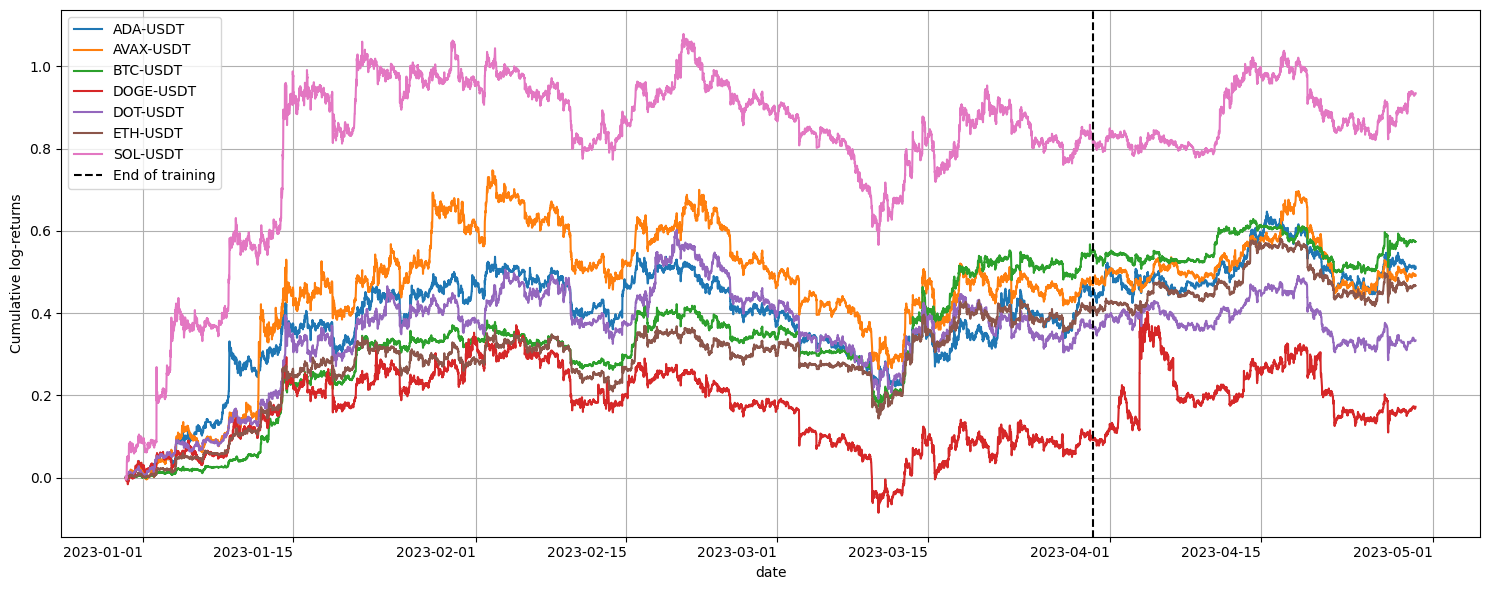

In [24]:
all_data_train_test =pd.concat([raw_data_test,raw_data_train]).close[::-1]
all_data_train_test = np.log(all_data_train_test.pct_change() + 1).cumsum()
fig,ax = plt.subplots(1,1,figsize = (15,6))
all_data_train_test.plot(ax=ax,grid = True)
ax.set_ylabel("Cumulative log-returns")
y_min,y_max = ax.get_ylim()
ax.vlines(x = raw_data_train.index[0],ymin=y_min*1.2,ymax=y_max*1.2,color="black",linestyle="dashed",label="End of training")
ax.set_ylim((y_min,y_max))
ax.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Data pre-processing

In [25]:
n = 50
data_train_dataframe,index_train,data_train_ST = data_process(raw_data_train,cryptos,n=n)
data_test_dataframe,index_test,data_test_ST = data_process(raw_data_test,cryptos,n=n)

## Agent definition

Learning ...
tensor([[-0.2338, -0.3622, -0.5726]])


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]



 tensor([[3.7582, 3.6221, 3.4103]])


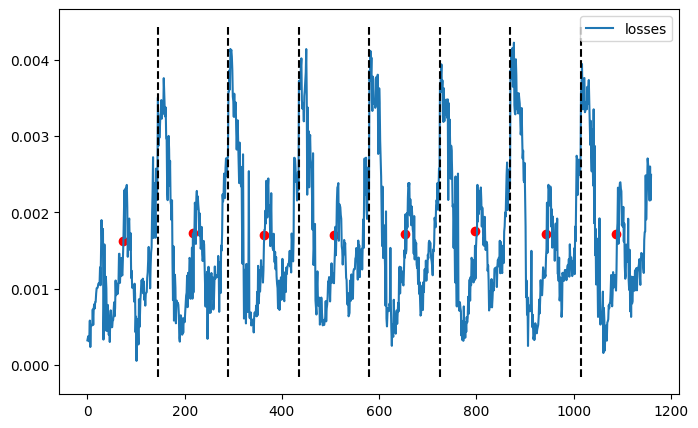

In [50]:
print("Learning ...")

#Training hyperparameters
epoch =  8
N_b = 3
n_b = 25
m = len(cryptos)

#Cash parameters
fees_in_bps = 0.
cash_bias = 0.
cash_bias_update_rate = 0.5
fees_simu = 25.

#Learning Hyperparameters
tau = 0.8
lr_eta = 0.01
beta_replay_buffer = 0.2


#Setting up the agent and environnement
env_memory = Env_PVM(m = m,n = n , training_data = data_train_ST,\
                     batch_size_N_b = N_b,mini_batch_lenght_n_b = n_b,\
                     cryptos = cryptos,beta = beta_replay_buffer)
agent = Agent(n=n,m=m,pvm = env_memory,tau = tau,lr_policy=lr_eta,\
              fees = fees_in_bps*ONE_BPS,network_class = ActorNetwork,\
              cash_bias = cash_bias,cash_bias_update_rate = cash_bias_update_rate)

#Training the agent
agent.train(epoch = epoch,plot_reward = True)

## Backtests

### Train set


Value stock is  SOL-USDT
Markowitz weights : BTC-USDT: 0.93 | ETH-USDT: 0.07 | ADA-USDT: 0.00 | SOL-USDT: 0.00 | DOT-USDT: 0.00 | DOGE-USDT: 0.00 | AVAX-USDT: 0.00
Fees backtest : 25.0 BPS


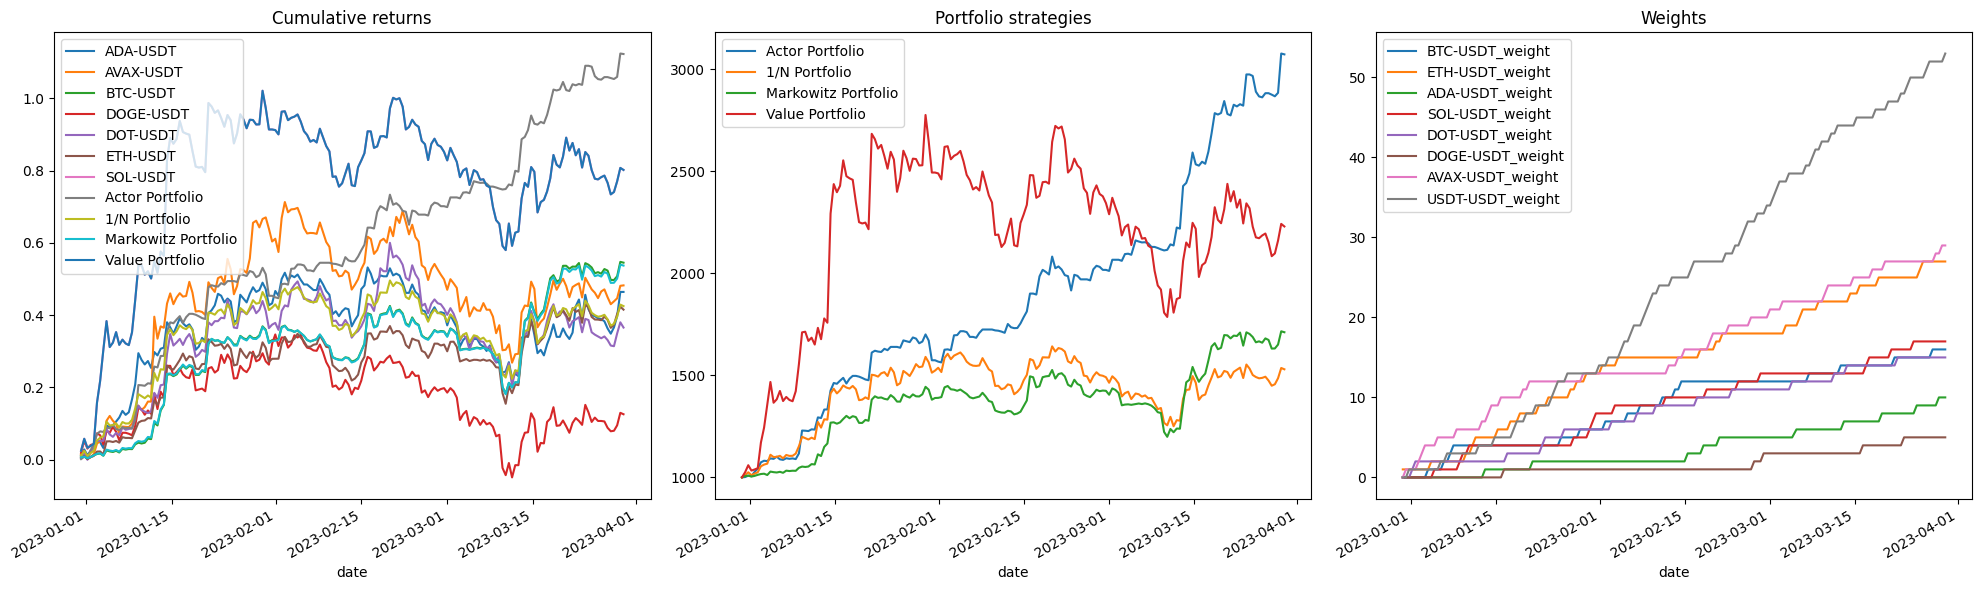

,Sharpe ratio,% return,Final price,Max drawdown
Actor Portfolio,5.163890,207.269415,3072.694147,-0.080622
1/N Portfolio,1.855091,52.966930,1529.669297,-0.238324
Markowitz Portfolio,2.462155,71.128307,1711.283074,-0.214518
Value Portfolio,1.944932,122.955975,2229.559748,-0.356495


In [51]:
backtest, backtest_cumsum= agent.backtest(raw_data_test = raw_data_train,data_test = data_train_ST,index_data_test = index_train,fees_override = ONE_BPS * fees_simu)

fig,axs = plt.subplots(1,3,figsize= (20,6))

ax = axs[0]
backtest_cumsum[[c for c in backtest_cumsum.columns if "USDT-" not in c]].plot(ax = ax)
ax.set_title("Cumulative returns")
ax = axs[1]
backtest[[c for c in backtest.columns if "USDT" not in c]].plot(ax = ax)
ax.set_title("Portfolio strategies")
ax = axs[2]
backtest[[c for c in backtest.columns if "weight" in c]].cumsum().plot(ax=ax)
ax.set_title("Weights")
plt.tight_layout()
plt.show()

performance_metric(backtest[[c for c in backtest.columns if "USDT" not in c]].dropna())

#### Figures for the report

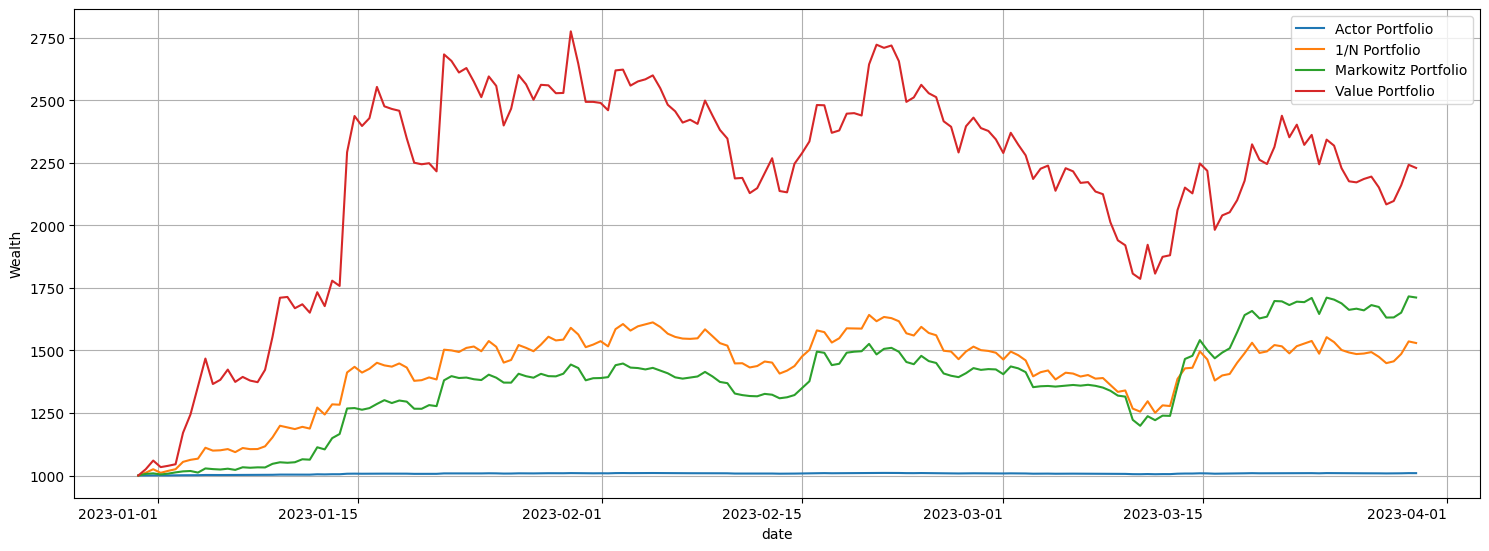

In [35]:
fig,ax = plt.subplots(1,1,figsize = (15,6))
backtest[[c for c in backtest.columns if "USDT" not in c]].plot(ax = ax)
ax.set_ylabel("Wealth")
ax.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

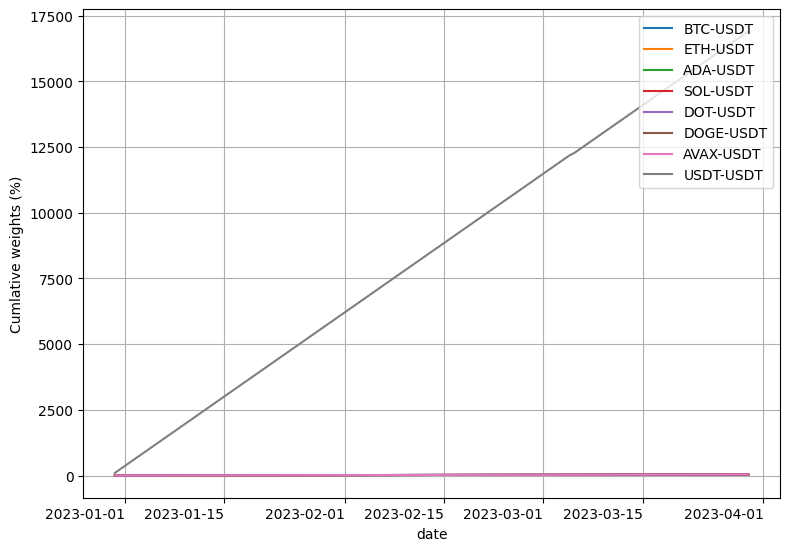

In [36]:
fig,ax = plt.subplots(1,1,figsize = (8,6))
((backtest[[c for c in backtest.columns if "weight" in c]].rename(columns = {s:s.replace("_weight","") for s in backtest.columns if "weight" in s}) * 100).cumsum()).plot(ax = ax)
ax.set_ylabel("Cumlative weights (%)")
ax.grid(True)
ax.legend(loc="upper right")
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

### Test set


Value stock is  SOL-USDT
Markowitz weights : BTC-USDT: 0.94 | ETH-USDT: 0.06 | ADA-USDT: 0.00 | SOL-USDT: 0.00 | DOT-USDT: 0.00 | DOGE-USDT: 0.00 | AVAX-USDT: 0.00
Fees backtest : 25.0 BPS


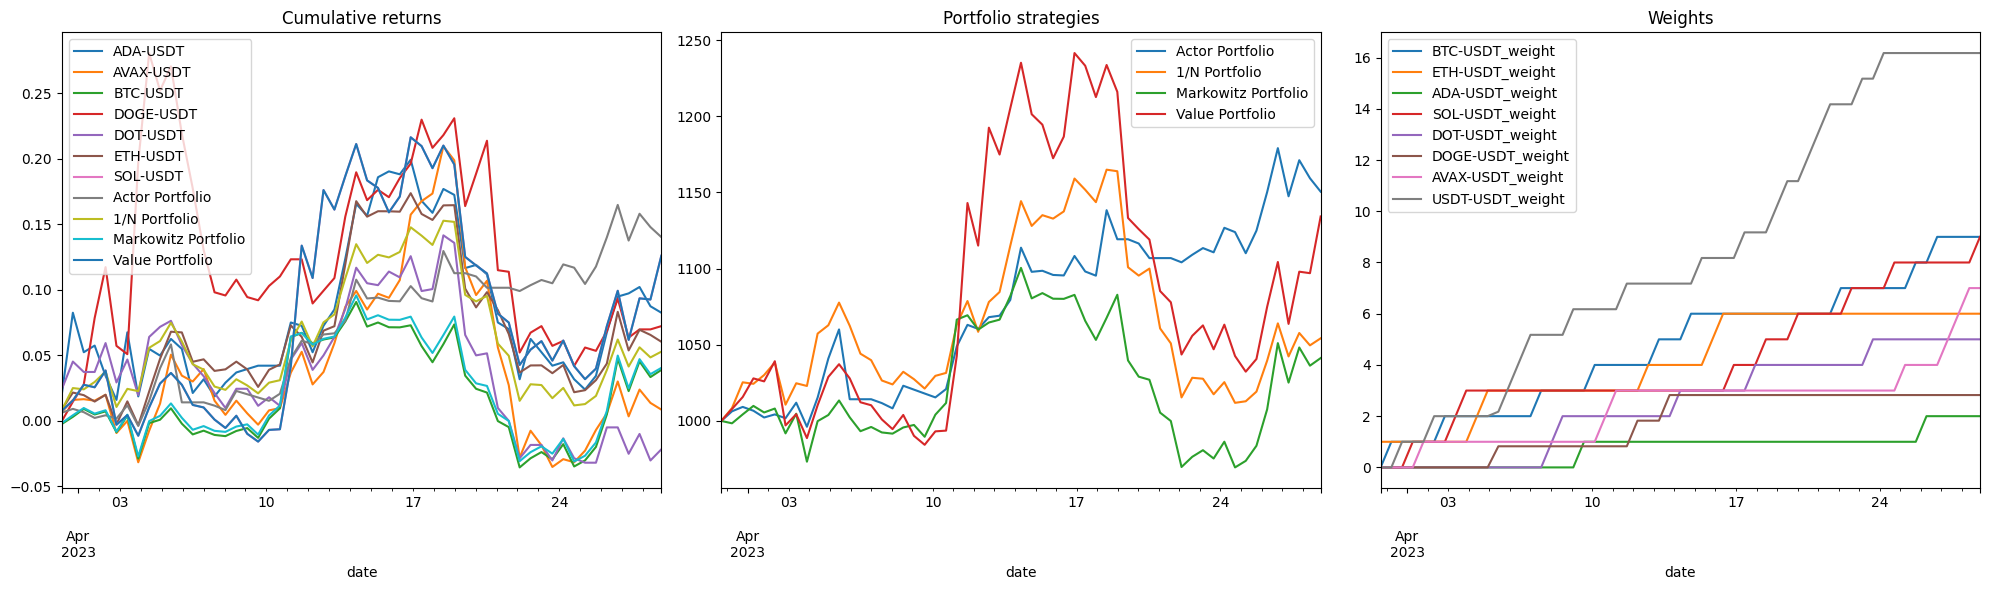

,Sharpe ratio,% return,Final price,Max drawdown
Actor Portfolio,2.922030,15.053489,1150.534886,-0.048889
1/N Portfolio,1.020971,5.423182,1054.231821,-0.131420
Markowitz Portfolio,0.822122,4.125464,1041.254644,-0.119049
Value Portfolio,1.535446,13.424792,1134.247918,-0.168508


In [52]:
backtest_test, backtest_cumsum_test= agent.backtest(raw_data_test = raw_data_test,data_test = data_test_ST,index_data_test = index_test,fees_override = ONE_BPS * fees_simu)

fig,axs = plt.subplots(1,3,figsize= (20,6))

ax = axs[0]
backtest_cumsum_test[[c for c in backtest_cumsum_test.columns if "USDT-" not in c]].plot(ax = ax)
ax.set_title("Cumulative returns")
ax = axs[1]
backtest_test[[c for c in backtest_test.columns if "USDT" not in c]].plot(ax = ax)
ax.set_title("Portfolio strategies")
ax = axs[2]
backtest_test[[c for c in backtest_test.columns if "weight" in c]].cumsum().plot(ax=ax)
ax.set_title("Weights")
plt.tight_layout()
plt.show()

performance_metric(backtest_test[[c for c in backtest_test.columns if "USDT" not in c]].dropna())

#### Figures for the report

<ipython-input-38-d609ca050543>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


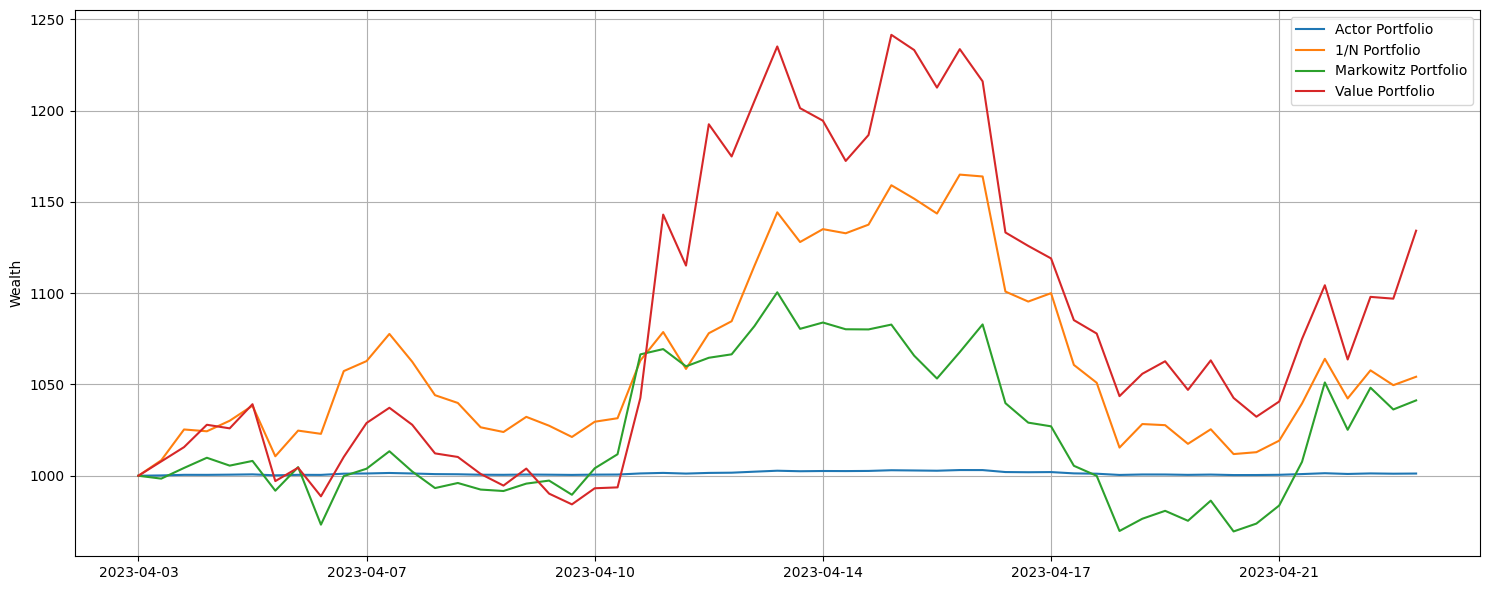

In [38]:
fig,ax = plt.subplots(1,1,figsize = (15,6))
backtest_test[[c for c in backtest_test.columns if "USDT" not in c]].plot(ax = ax,use_index=False)
ax.set_ylabel("Wealth")
ax.grid(True)

len_labels = len(ax.get_xticklabels())
len_new_labels = len(backtest_test.index)

new_labels = [backtest_test.index[i * len_new_labels //  len_labels] for i in range(len_labels)]  + [backtest_test.index[-1]]
new_labels = [dd.date() for dd in new_labels]
ax.set_xticklabels(new_labels)

xlabel=backtest_test.index

plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

<ipython-input-39-3399a48441e2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


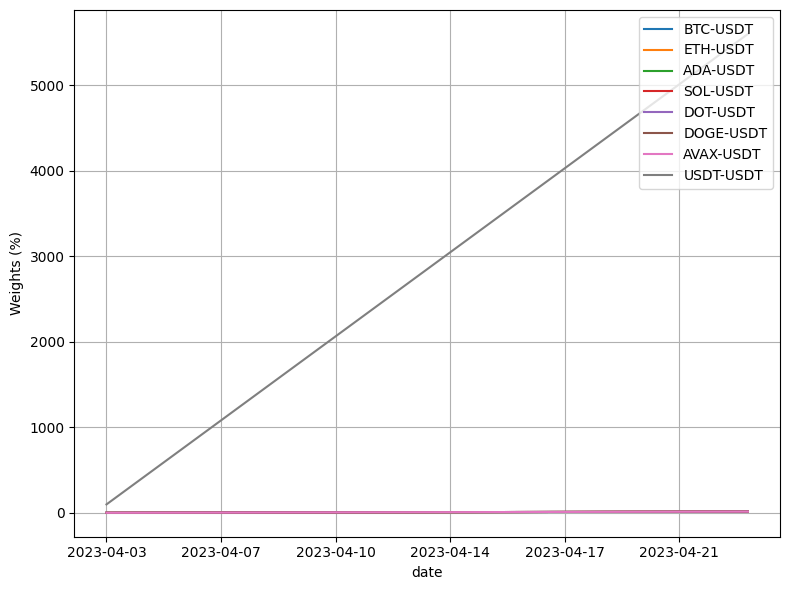

In [39]:
fig,ax = plt.subplots(1,1,figsize = (8,6))
(backtest_test[[c for c in backtest_test.columns if "weight" in c]].rename(columns = {s:s.replace("_weight","") for s in backtest_test.columns if "weight" in s}) * 100).cumsum().plot(ax = ax,use_index=False)
ax.set_ylabel("Weights (%)")
ax.grid(True)
ax.legend(loc="upper right")

len_labels = len(ax.get_xticklabels())
len_new_labels = len(backtest_test.index)

new_labels = [backtest_test.index[i * len_new_labels //  len_labels] for i in range(len_labels)]  + [backtest_test.index[-1]]
new_labels = [dd.date() for dd in new_labels]
ax.set_xticklabels(new_labels)
ax.set_xlabel("date")

plt.tight_layout()
plt.xticks(rotation=0)
plt.show()